NameError: name 'scrapedate' is not defined

In [3]:
import requests
import json
import pickle
import os
import numpy as np
import time
import shutil
import datetime
import cv2
import urllib.request
import sqlite3 as sql
import base64
import ffmpy3
from file_read_backwards import FileReadBackwards

In [28]:
## Featurizer featurizes methods that convert json objects of the appropriate type into features

class Featurizer:
    def __init__(self):
        pass
        #self.name = name

    # takes in text pickle and scrapedate, returns vector of 14 elements
    # the first element is count of texts sent in the 24 hours before the scrape
    # the last element is count of texts sent on the 24 hour window 14 days before the scrapedate
    def textFreqVec14(self, text, scrapedate):
        
        textFreqVec = np.zeros((14,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # moving average index
        n = 5
        
        # assuming unordered texts (WHICH TURNS OUT IS THE CASE)
        for day in range(0,14):
            time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
            time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
            for t in range(0,len(text)):
                text_date = int(json.loads(text[t])['date'].encode('ascii','ignore'))
                if ((time_during_week_ub > text_date) and (text_date > time_during_week_lb)):
                    textFreqVec[day] += 1.0
                    
        return textFreqVec
    

    # takes in call pickle and scrapedate, returns vector of 14 elements
    # the first element is count of calls sent in the 24 hours before the scrape
    # the last element is count of calls sent on the 24 hour window 14 days before the scrapedate
    def callFreqVec14(self, call, scrapedate):
        
        callFreqVec = np.zeros((14,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # moving average index
        n = 5
        
        for day in range(0,14):
            time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
            time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
            for c in range(0,len(call)):
                call_date = int(json.loads(call[c])['date'].encode('ascii','ignore'))
                if ((time_during_week_ub > call_date) and (call_date > time_during_week_lb)):
                    callFreqVec[day] += 1.0
                    
        return callFreqVec
    
    
    # input is tweets pickle, return master vector
    def embeddingToMastersum(self, tweets):
        
        masterSum = np.zeros((300,))

        # add every word vector into master sum
        for i in range(0,len(tweets)):
            try:
                masterSum += self.tweetToEmbedding(tweets[i])
            except:
                pass
        
        return masterSum

    
    # input is one single tweet, returns vector embedding of entire tweet.
    # eg: responseobject.json()[0]
    def tweetToEmbedding(self, tweet):

        q = tweet['text'].split()

        sumVector = np.zeros((300,))

        # turn every word into embedding for 1 tweet, add all vectors
        for i in range(0,len(q)):
            try:
                sumVector += model[q[i]]
            except KeyError:
                pass
            except IndexError:
                pass

        return sumVector
    
    
    # input is tweets pickle, returns follow count
    def followerCount(self, tweets):

        followerCount = 0

        # get
        try:
            followerCount = json.loads(tweets[0])['user']['followers_count']
        except KeyError:
            pass
        except IndexError:
            pass

        return followerCount

    # input is tweets pickle, returns friend count
    def followingCount(self, tweets):

        followingCount = 0

        try:
            followingCount = json.loads(tweets[0])['user']['friends_count']
        except KeyError:
            pass
        except IndexError:
            pass

        return followingCount

    # input is tweets pickle, return avg likes per post for the last 2 weeks
    def twitterLikeFreq(self, tweets, scrapedate):

        twitLikeVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(tweets)):

            utc = json.loads(tweets[t])['created_at']

            tweet_date = int(time.mktime(time.strptime(utc,"%a %b %d %H:%M:%S +0000 %Y"))) * 1000

            if ((time_during_week_ub > tweet_date) and (tweet_date > time_during_week_lb)):
                twitLikeVec[0] += 1.0
                    
        return twitLikeVec/14


    # input is tweets pickle, return avg retweets per post for the last 2 weeks
    def twitterRetweetFreq(self, tweets, scrapedate):

        twitRTVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(tweets)):

            utc = json.loads(tweets[t])['created_at']

            tweet_date = int(time.mktime(time.strptime(utc,"%a %b %d %H:%M:%S +0000 %Y"))) * 1000

            if ((time_during_week_ub > tweet_date) and (tweet_date > time_during_week_lb)):
                twitRTVec[0] += json.loads(tweets[i])['favorite_count']
                    
        return twitRTVec/14
    
    # input is contacts pickle, returns number of contacts
    def numOfContacts(self, contacts):
        return len(contacts)
    
    # input is instagram pickle, return two features: follows count, followed by count  
    def instagramThings(self, instagram):
        
        followsFollowed = np.zeros((2,))
        
        try:
            if(type(json.loads(instagram[0])) == str):
                print("DAMN YOU DAMON!!(ig)")
            else: # its a dictionary like it's supposed to be
                followsFollowed[0] = json.loads(instagram[0])['data']['counts']['follows']
                followsFollowed[1] = json.loads(instagram[0])['data']['counts']['followed_by']
        except IndexError:
            pass
        
        return followsFollowed
    
    # takes in instagramMedia pickle scrape date, spits out filter usage frequency for the past 2 weeks
    def instagramFilterFreq(self, instagramMedia, scrapedate):
        
        instaFiltVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_at']
            
            if(this != '[object Object]'):
                    igpost_date = int(json.loads(this)['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                instaFiltVec[0] += 1.0
                    
       
        nofilter_count = 0

        for i in range(0,instaFiltVec[0]):
            if(json.loads(tweets[i])['filter'] == Normal):
                nofilter_count += 1
        
        instaFiltVec[0] -= nofilter_count
        
        return instaFiltVec
        
       
    
    # takes in instagramMedia pickle and scrape date, returns a vector that
    # contains a normalized percentage (0-1) for the usage of the filters
    # listed below for the past 2 weeks: 
    # Valencia, X-Pro II, Hefe, Amaro, Rise, Willow, Crema, Inkwell
    
    # output example: [0.5,0,0,0,0,0.5,0,0] 
    # interpretation: user used valencia half the time, Willow the other half
    # of time, for the past 2 weeks of Instagram posts.1`sas
    def instagramFilterVector(self, instagramMedia, scrapedate):
        
        filters = {'Valencia':0,'X-Pro II':0, 'Hefe':0, 'Amaro':0, 'Rise':0, 'Willow':0, 'Crema':0, 'Inkwell':0}
        filtervec = np.zeros((8,))
        
        numposts = 0
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(tweets)):

            utc = json.loads(tweets[t])['created_at']
            
            if(this != '[object Object]'):
                igpost_date = int(json.loads(this)['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                numposts += 1.0
                
                
        for i in range(0,numposts):
            filt = json.loads(instagramMedia[i])['filter']
            if(filt in filters):
                filters[filt] += 1
            else:
                pass
            
        for i in range(0,8):
            filtervec[i] = filters[list(filters)[i]]

        # percentage of how much the filters are used as a normalized vector
        return filtervec/(numposts)
    
    # takes in InstagramMedia, returns comment and like frequency for the 
    # past 2 weeks.
    def instagramLikeComFreq(self, instagramMedia, scrapedate):
        
        counts = np.zeros((2,))
        
        postcount = 0
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_at']
            
            if(this != '[object Object]'):
                    igpost_date = int(json.loads(this)['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                postcount += 1.0
        
        for i in range(0,postcount):
            counts[0] += json.loads(instagramMedia[i])['likes']['count']
            counts[1] += json.loads(instagramMedia[i])['comments']['count']
        
        if (counts[0] + counts[1] == 0):
            return np.zeros((2,))
        else:
            # likes per post for past 2 weeks
            return counts/postcount


    # takes in instagramMedia pickle and scrapedate, returns IG post 
    # frequency for the past 2 weeks
    def instagramPostFreq(self, instagramMedia, scrapedate):
        
        postcount = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_at']
            
            if(this != '[object Object]'):
                    igpost_date = int(json.loads(this)['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                postcount[0] += 1.0
                
        return postcount/14
        
        
    # takes instagramMedia, returns pixelwise average values for [H,S,V]
    # (Hue, Saturation, Value) for all posts in the past 2 weeks, the 
    # count of faces as a frequency of faces per picture, for the past
    # 2 weeks as well.
    
    # testvariable:
    # empty string: "" if not testing
    # 
    def averageHSVF(self, instagramMedia, scrapedate):


        seconds_intwo_weeks = 1209600;

        ## ms into secs
        scrapedate = int(str(scrapedate)[:-3]) 

        two_weeks_prior = scrapedate - seconds_intwo_weeks

        igpost_date = 0
        saved_index = 0

        a = instagramMedia

        # find the index of the oldest call that is not older than the date "two weeks prior"
        for i in range(0,len(a)):
            try:
                this = a[len(a)-(i+1)]
                if(this != '[object Object]'):
                    igpost_date = int(json.loads(this)['created_time'])
                else:
                    print("DAMN YOU DAMON!!(ig)")
            except KeyError:
                pass
            except IndexError:
                pass

            if (two_weeks_prior < igpost_date):
                saved_index = len(a) - (i+1)
                break


        

        if(os.path.exists("./ILLSTOPBLINKINGSOON")):
            shutil.rmtree('./ILLSTOPBLINKINGSOON')

        os.mkdir('./ILLSTOPBLINKINGSOON')

        avgs = np.zeros((4,))

        ## to avoid division by 0
        if(saved_index == 0):
            return avgs



        for i in range(0,saved_index):
            url = json.loads(instagramMedia[i])['images']['thumbnail']['url']
            urllib.request.urlretrieve(url, './ILLSTOPBLINKINGSOON/' + str(i) + '.jpg')


        # face_cascade here is a pre trained classifier for frontal faces 
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

            
        avgHue = 0
        avgSatur = 0
        avgVal = 0
        avgFaces = 0

        ## GODS OF PROGRAMMING, FORGIVE ME FOR THIS TRIPLE NEST

        for k in range(0, saved_index):
            ## BGR and not RGB because imread reads in BGR
            img = cv2.imread('./ILLSTOPBLINKINGSOON/' + str(k) + '.jpg')
            
            hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
            
            grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(grayImage,  scaleFactor=1.1, minNeighbors=5, flags = cv2.CASCADE_SCALE_IMAGE)
            
            avgFaces += len(faces)
            
            for i in range(0,hsv.shape[0]):
                for j in range(0,hsv.shape[1]):
                    avgHue += hsv[i,j,0]
                    avgSatur += hsv[i,j,1]
                    avgVal += hsv[i,j,2]
                    
        

        sums = [avgHue,avgSatur,avgVal]

        ## 22500 = 150x150 = instagram photo thumbnail shape
        avgs = list(map(lambda x: x/(22500*saved_index), sums)).append(avgFaces/saved_index)

        shutil.rmtree('./ILLSTOPBLINKINGSOON')

        return avgs      

    
    #input is texts pickle, return master vector 
    def embeddingToMastersumText(self, texts):
        
        masterSum = np.zeros((300,))

        # add every word vector into master sum
        for i in range(0,len(texts)):
            try:
                masterSum += self.textToEmbedding(texts[i])
            except:
                pass
        
        return masterSum

    
    # input is single text, returns vector embedding of entire text.
    def textToEmbedding(self, text):
        
        q = json.loads(text)["body"].split()

        sumVector = np.zeros((300,))

        # turn every word into embedding for 1 tweet, add all vectors
        for i in range(0,len(q)):
            try:
                sumVector += model[q[i]]
            except KeyError:
                pass
            except IndexError:
                pass

        return sumVector
    
    
    # returns [q1,q2,q3,q4,q5,q6,q7,q8,q9] and sum of all these scores
    def labelGenerator(self, phq):
        
        labelVector = np.zeros((10,))
        sumOfScores = 0
        
        # print(phq)
        
        for i in range(0,9):
            temp = int(json.loads(phq[0])['Q' + str(i)])
            labelVector[i] = temp
            labelVector[9] += temp
            
        return labelVector

    

        
    def voiceFeaturizer(self, voice):

        audiofeaturevec = np.zeros((1583,))

        if(len(voice) == 0):
            return audiofeaturevec

        # base64 string -> bitstring -> bitstream -> write into 3gp file
        bytestream = base64.b64decode(voice[0])
        fh = open("audio.3gp","wb")
        fh.write(bytestream)
        fh.close()

        # wav -> 3gp
        ff = ffmpy3.FFmpeg( inputs={'audio.3gp': None}, outputs={'audio.wav': None})
        ff.run()

        os.remove("audio.3gp")

        # call to openSMILE
        os.system( os.getcwd() + '/openSMILE-2.1.0/bin/linux_x64_standalone_static/SMILExtract -C ' + os.getcwd() + '/openSMILE-2.1.0/config/emobase2010.conf -I audio.wav -O "out.csv"')

        os.remove("audio.wav")

        # csv file has a giant header. last line contains the features we want
        # so we read the last line, cut out more useless string with 'l[9:]
        with FileReadBackwards("out.csv", encoding="utf-8") as frb:
            for l in frb:
                b = l[9:].split(',')
                break

        os.remove("out.csv")

        # make list of string into list of floats
        a = list(map(float, b))

        # make sklearn happy
        for i in range(0,len(a)):
            audiofeaturevec[i] = a[i]

        return audiofeaturevec

In [7]:
import unittest
import os
import pickle
import numpy as np
import json

# f = Featurizer()

b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "Instagram media" + ".p", "rb" ))        
# for i in range(0,len(b1)):
#     print(int(json.loads(b1[i])['date'].encode('ascii','ignore')))

igpost_date = int(json.loads(b1[0])['created_time']) * 1000
igpost_date

1514323274000

In [4]:
b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "audio" + ".p", "rb" ))        

len(b1)

1

In [206]:
import base64
import ffmpy3
import os
from file_read_backwards import FileReadBackwards

# base64 string -> bitstring -> bitstream -> write into 3gp file
bytestream = base64.b64decode(voice[0])

NameError: name 'voice' is not defined

In [74]:
class TestFeaturizer(unittest.TestCase):
    
    if __name__ == '__main__':
        unittest.main(argv=['first-arg-is-ignored'], exit=False)
    
    def test_labelGenerator(self):
        b1 = pickle.load(open( "datafor16:13" + "/DP" + "7276" +  "phq" + ".p", "rb" ))
        self.assertSequenceEqual(f.labelGenerator(b1).tolist(),[3,1,0,2,0,0,0,0,0,6])
        
    def test_textFreqVec14(self):
        b1 = pickle.load(open( "datafor16:13" + "/DP" + "0660" +  "text" + ".p", "rb" ))
        self.assertSequenceEqual(f.textFreqVec14(b1,1515042722290),[2, 3, 0, 0, 2, 5, 4, 2, 2, 2, 1, 1, 2, 0])
        
    def test_callFreqVec14(self):
        b1 = pickle.load(open( "datafor16:13" + "/DP" + "5904" +  "log" + ".p", "rb" ))
        self.assertSequenceEqual(f.callFreqVec14(b1,1515042722290),[23, 34, 16, 6, 8, 26, 0, 0, 0, 0, 0, 0, 0, 0])    
        
    def test_dailyTextFre(self):
        self.assertEqual(4,4)
        
    def add(self,x,y):
        return x + y
        
    def test_errorexample(self):
        self.assertRaises(TypeError,self.add,"3",4)    

/home/vape/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.BufferedReader name='datafor16:13/DP5904log.p'>
  from ipykernel import kernelapp as app
E../home/vape/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='datafor16:13/DP7276phq.p'>
  import sys
./home/vape/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='datafor16:13/DP0660text.p'>
  # This is added back by InteractiveShellApp.init_path()
E
ERROR: test_callFreqVec14 (__main__.TestFeaturizer)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-72-5a4136992325>", line 16, in test_callFreqVec14
    self.assertSequenceEqual(f.callFreqVec14(b1,1515042722290),[23, 34, 16, 6, 8, 26, 0, 0, 0, 0, 0, 0, 0, 0])
  File "/usr/lib/python3.5/unittest/case.py", line 944, in assertSequenc

In [322]:
b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "Instagram media" + ".p", "rb" ))
len(b1)

igpost_date = int(json.loads(b1[0])['created_time'])
igpost_date

1514323274

In [220]:
## PREPROCESSING

from sklearn.preprocessing import Imputer

# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
mtr = imp.fit_transform(mtr)

# normalize (features now have gauss dist., 0 mean and unit variance)
mtr = sklearn.preprocessing.scale(mtr)

# all of our data
bigBadMatrix = g.featureMatrix

# shuffle row-wise
np.random.shuffle(bigBadMatrix)




# DATA SPLIT (#nosnooping)

# TEST DATA (%15 percent of data)
numofppl_index = ftrMtrx.shape[0] - 1
cut_index = int(ftrMtrx.shape[0] * 0.85)

test_data = bigBadMatrix[cut_index:numofppl,:]

# TRAINING AND TEST DATA (%85 percent of data)

train_data = bigBadMatrix[0:cut_index,:]









## hyper parameter optimization

from sklearn.grid_search import GridSearchCV







c_range = list(range(1, 30))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid', 'precomputed'), 'C':c_range}
parameters['kernel']

from sklearn.grid_search import GridSearchCV
from sklearn import svm



np.random.shuffle



svc = svm.SVC()
grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')

clf.fit()


('linear', 'rbf', 'poly', 'sigmoid', 'precomputed')

In [17]:
b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "Instagram media" + ".p", "rb" ))

filt = json.loads(b1[0])['filter']
filt

'Normal'

In [336]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], np.int32)
x

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]], dtype=int32)

In [337]:
x[:,0:1] # subcolumn

array([[ 1],
       [ 4],
       [ 7],
       [10]], dtype=int32)

In [292]:
x[0:2,:] #subrow 

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

In [21]:
np.random.shuffle(x)
x

array([[ 7,  8,  9],
       [ 1,  2,  3],
       [10, 11, 12],
       [ 4,  5,  6]], dtype=int32)

In [339]:
ftypes = ["au","ig","txt","con","tw","call","all"]
for i in ftypes:
    print(i)

au
ig
txt
con
tw
call
all


In [16]:
import numpy as np
import pickle

In [42]:
# print(phq)
phq = pickle.load(open( "datafor23:41" + "/DP" + "9984" +  "phq" + ".p", "rb" ))
labelVector = np.zeros((10,))
sumOfScores = 0

# print(phq)

for i in range(0,9):
    print(i)
    temp = int(json.loads(phq[0])['Q' + str(i)])
    
    labelVector[i] = temp
    labelVector[9] += temp

labelVector

0
1
2
3
4
5
6
7
8


array([ 3.,  2.,  3.,  3.,  2.,  2.,  1.,  0.,  2., 18.])

In [34]:
import sqlite3 as sql
# connect to file
conn = sql.connect('phonedata.db')
# create cursor for making calls to database
c = conn.cursor()

list_of_approved_ids = []
text_file = open("codes.txt", "r")
list_of_approved_ids = text_file.read().split('\n')
del list_of_approved_ids[-1]

list_of_ids = []



for row in c.execute('SELECT * FROM ids'):
    # one result
    if (row[0] in list_of_approved_ids):
        list_of_ids.append(row[0])
    

len(list_of_ids)

261

In [43]:
list_of_ids = l.lids()
for idd in range(0,len(list_of_ids)):
    # print(phq)
    phq = pickle.load(open( "datafor23:41" + "/DP" + str(list_of_ids[idd]) +  "phq" + ".p", "rb" ))
    labelVector = np.zeros((10,))
    sumOfScores = 0

    # print(phq)

    for i in range(0,9):
        print(i)
        temp = int(json.loads(phq[0])['Q' + str(i)])

        labelVector[i] = temp
        labelVector[9] += temp

    print(labelVector[9])

NameError: name 'l' is not defined

In [48]:
np.hstack((x[:,0:1],x[:,2:3], x[:,1:2]))

array([[ 1,  3,  2],
       [ 4,  6,  5],
       [ 7,  9,  8],
       [10, 12, 11]], dtype=int32)

In [63]:
featureVectorCF = np.zeros((14,1))
featureVectorCF[2:3,:] = np.nan
featureVectorCF
import pandas

In [67]:
messages = pandas.read_csv('SMSSpamCollection',
                           sep='\t',names=['labels','message'])

In [264]:
b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "text" + ".p", "rb" ))
len(b1)

q = json.loads(b1[0])["body"]
q

'I slept pretty well last night '

In [101]:
q = text_process(q)
text = nltk.Text(q)
tags = nltk.pos_tag(text)

In [133]:
newtagdic = {}
for key in tagdict.keys():
    newtagdic[key] = 0

tags

[('slept', 'NN'),
 ('pretty', 'RB'),
 ('well', 'RB'),
 ('last', 'JJ'),
 ('night', 'NN')]

In [140]:
for tag in tags:
    print(tag[1])

NN
RB
RB
JJ
NN


In [104]:
from collections import Counter
counts = Counter(tag for word,tag in tags)
counts

Counter({'JJ': 1, 'NN': 2, 'RB': 2})

In [123]:
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
tagdict.keys()

dict_keys(['RBS', 'JJS', 'RBR', 'CC', 'PDT', '(', 'MD', '$', 'VB', 'VBN', '``', 'NNS', 'WP$', 'CD', '.', 'PRP', ':', 'WP', 'JJR', 'FW', 'DT', 'LS', 'EX', 'JJ', 'IN', 'PRP$', 'NN', 'POS', 'VBG', 'WDT', 'VBZ', 'RB', ',', 'TO', 'NNP', 'VBP', 'SYM', 'WRB', ')', 'VBD', '--', 'NNPS', 'UH', "''", 'RP'])

In [135]:
len(tags)

5

In [307]:



b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "text" + ".p", "rb" ))

q = json.loads(b1[0])["body"]



for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.125


In [333]:

def SentAnalysis(text, scrapedate):
    
    if(len(text) == 0):
        return np.zeros((14,))
    
    SentFreqVec = np.zeros((14,))
    
    def text_process(mess):
        # Remove all punctuation, stopwords
        nopunc = [char for char in mess if char not in string.punctuation]
        nopunc = ''.join(nopunc)
        return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    # moving average index
    n = 10

    mseconds_in_twoweeks = 1209600000;
    mseconds_in_day = 86400000;

    # assuming unordered texts (WHICH TURNS OUT IS THE CASE)
    for day in range(0,14):
        time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
        for t in range(0,len(text)):
            text_date = int(json.loads(text[t])['date'].encode('ascii','ignore'))
            if ((time_during_week_ub > text_date) and (text_date > time_during_week_lb)):
                
                body = json.loads(text[t])["body"]
                blob = TextBlob(" ".join(text_process(body)))
                
                SentFreqVec[day] += blob.sentiment.polarity
    
    return SentFreqVec

In [334]:
b1 = pickle.load(open( "datafor16:13" + "/DP" + "8619" +  "text" + ".p", "rb" ))

x = SentAnalysis(b1, 1515043370034)
x

array([ 8.77980519,  9.87266234,  8.87948052,  8.35296537, 12.62329004,
       14.52794372, 18.97794372, 20.28984848, 21.08984848, 23.68984848,
       24.91484848, 26.03734578, 27.54290133, 27.79409181])

In [341]:

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

knn = KNeighborsClassifier(n_neighbors=5)


from sklearn.grid_search import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [368]:
contactsStartEnd = [0,1]
contactsStartEnd[2]

IndexError: list index out of range

In [342]:
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [347]:
grid.grid_scores_[0].mean_validation_score

0.96

In [441]:
# n gives nth phq answer
# 10 gives sum of all phqs
def Yer(y, n):
    return y[:,n-1:n]


contactsStartEnd = [0,1]
twitterStartEnd = [1,5]
textStartEnd = [5,78]
callStartEnd = [78,92]
instagramStartEnd = [92,110]
audioStartEnd = [110,1693]
allStartEnd = [contactsStartEnd[0], audioStartEnd[1]]


ftypes = ["au","ig","txt","con","tw","call","all"]

# ftype = "au" audio / "ig" instagram / "txt" text / "con" contacts / "tw" twitter / "call" call
# "all" = big matrix
def Xer(X, ftype):
    if(ftype == "au"):
        return X[:,audioStartEnd[0]:audioStartEnd[1]]
    if(ftype == "ig"):
        return X[:,instagramStartEnd[0]:instagramStartEnd[1]]
    if(ftype == "txt"):
        return X[:,textStartEnd[0]:textStartEnd[1]]
    if(ftype == "con"):
        return X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    if(ftype == "tw"):
        return X[:,twitterStartEnd[0]:twitterStartEnd[1]]
    if(ftype == "call"):
        return X[:,callStartEnd[0]:callStartEnd[1]]
    if(ftype == "all"):
        return X[:,allStartEnd[0]:allStartEnd[1]]

In [453]:
## ML TESTINGG


import pandas as pd
import sklearn

In [454]:
mtr = pd.read_csv("mtr.csv").values
mtr = np.delete(mtr, 0, axis = 1)
mtr.shape

(261, 1703)

In [455]:
mtr[0:10,1693:1704]


array([[ 2.,  1.,  2.,  1.,  2.,  3.,  2.,  1.,  2., 16.],
       [ 1.,  1.,  3.,  2.,  2.,  1.,  2.,  0.,  1., 13.],
       [ 2.,  3.,  2.,  0.,  0.,  1.,  0.,  1.,  2., 11.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  5.],
       [ 2.,  1.,  0.,  2.,  2.,  3.,  1.,  1.,  2., 14.],
       [ 1.,  2.,  0.,  1.,  0.,  3.,  0.,  0.,  1.,  8.],
       [ 2.,  3.,  2.,  2.,  3.,  2.,  2.,  3.,  2., 21.],
       [ 3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  5.]])

In [456]:
## PREPROCESSING
import pandas as pd
from sklearn.preprocessing import Imputer

# shuffle row-wise
np.random.shuffle(mtr)

data = mtr[:,0:1693]
labels = mtr[:,1693:1704]

# normalize data (features now have gauss dist., 0 mean and unit variance)
data = sklearn.preprocessing.scale(data)

# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

# If NaNs should be dropped instead:
# mtr = mtr[~np.isnan(mtr).any(axis=1)]




In [457]:
labels[0:10]

array([[ 3.,  2.,  1.,  1.,  3.,  3.,  2.,  0.,  0., 15.],
       [ 2.,  3.,  2.,  0.,  0.,  1.,  0.,  1.,  2., 11.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  7.],
       [ 2.,  2.,  1.,  1.,  1.,  0.,  1.,  2.,  0., 10.],
       [ 1.,  1.,  3.,  1.,  2.,  1.,  1.,  1.,  1., 12.],
       [ 2.,  1.,  2.,  1.,  3.,  1.,  1.,  1.,  0., 12.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  2.,  1.,  2.,  1.,  3.,  2.,  0.,  1., 13.],
       [ 2.,  3.,  2.,  3.,  3.,  3.,  3.,  2.,  1., 22.],
       [ 2.,  2.,  3.,  3.,  1.,  1.,  2.,  0.,  2., 16.]])

In [458]:
# DATA SPLIT (#nosnooping)

# TEST DATA (%15 percent of data)
numofppl_index = mtr.shape[0] - 1
cut_index = int(mtr.shape[0] * 0.85)

test_label = labels[cut_index:numofppl_index,:]
test_data = data[cut_index:numofppl_index,:]

# TRAINING AND VALIDATION DATA (%85 percent of data)

train_label = labels[0:cut_index,:]
train_data = data[0:cut_index,:]

In [478]:
lizz = train_label[:,9:10].tolist()
lizzn = []
for i in range(0,len(lizz)):
    lizzn.append(lizz[i][0])

In [479]:
from collections import Counter

Counter(lizzn)

Counter({0.0: 8,
         1.0: 6,
         2.0: 7,
         3.0: 6,
         4.0: 14,
         5.0: 12,
         6.0: 13,
         7.0: 11,
         8.0: 8,
         9.0: 10,
         10.0: 10,
         11.0: 13,
         12.0: 9,
         13.0: 6,
         14.0: 12,
         15.0: 7,
         16.0: 10,
         17.0: 8,
         18.0: 13,
         19.0: 8,
         20.0: 6,
         21.0: 11,
         22.0: 2,
         23.0: 1,
         24.0: 4,
         25.0: 3,
         26.0: 2,
         27.0: 1})

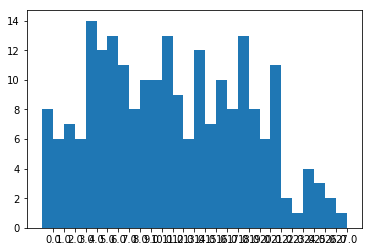

In [481]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*Counter(lizzn).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [449]:
phqcutoff = 18

for i in range(0,train_label[:,9:10].shape[0]):
    if(train_label[i][9] > phqcutoff):
        train_label[i][9] = 1
    else:
        train_label[i][9] = 0

In [438]:
# train_label[:,9:10]

In [450]:
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

results = np.zeros((10,7))

def HyperTunerSVM(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    phqscores = [1,2,3,4,5,6,7,8,9,10] # just for readability; 10 is sum
    for i in range(0,len(ftypes)):
        for j in range(0,len(phqscores)):
            
            X = Xer(trainX, ftypes[i])
            y = Yer(trainy, phqscores[j]).reshape(221,)
            
            c_range = list(range(1, 10))
            parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

            svc = svm.SVC()

            grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
            grid.fit(X, y)

            results[j][i] = grid.grid_scores_[0].mean_validation_score

            
HyperTunerSVM(train_data, train_label)

In [451]:
df = pd.DataFrame(results, columns=["au","ig","txt","con","tw","call","all"])
df

,au,ig,txt,con,tw,call,all
0,0.307692,0.334842,0.334842,0.321267,0.334842,0.321267,0.239819
1,0.289593,0.389140,0.389140,0.389140,0.389140,0.375566,0.289593
2,0.266968,0.276018,0.276018,0.266968,0.276018,0.307692,0.235294
3,0.257919,0.330317,0.330317,0.330317,0.330317,0.316742,0.276018
4,0.303167,0.312217,0.312217,0.294118,0.312217,0.312217,0.298643
5,0.330317,0.325792,0.325792,0.325792,0.325792,0.307692,0.321267
6,0.294118,0.352941,0.352941,0.339367,0.352941,0.343891,0.248869
7,0.552036,0.588235,0.588235,0.588235,0.588235,0.579186,0.533937
8,0.488688,0.538462,0.538462,0.538462,0.538462,0.542986,0.488688
9,0.769231,0.841629,0.841629,0.841629,0.841629,0.837104,0.760181
